In [666]:
def _get_subjects(dataset='test'):
    import s3fs
    
    fs = s3fs.S3FileSystem()
    
    afq_path = 'afq'
    
    if dataset == 'retest':
        afq_path = 'afq_retest'
        
    return [f.split('sub-')[1] for f in fs.glob(f'hcp.callosum/derivatives/{afq_path}/sub-*')]

In [678]:
def _download_and_combine_afq_profiles(dataset='test', save_csv=False):
    import s3fs
    from os.path import exists
    import pandas as pd

    fs = s3fs.S3FileSystem()

    dfs = []
    
    subjects = _get_subjects(dataset)
    
    afq_path = 'afq'
    
    if dataset == 'retest':
        afq_path = 'afq_retest'
    
    for subject in subjects:
        # NOTE assuming one session
        fname = f'sub-{subject}_dwi_space-RASMM_model-CSD_desc-prob-afq_profiles.csv'
        local_fname = f'hcp/{dataset}/{fname}'
        
        if not exists(local_fname):
            fs.get(
                f'hcp.callosum/derivatives/{afq_path}/sub-{subject}/ses-01/{fname}',
                local_fname
            )
        
        profiles = pd.read_csv(local_fname)
        profiles['subjectID'] = subject
        
        dfs.append(profiles)
        
    combined_df = pd.concat(dfs)
    
    if save_csv:
        combined_df.to_csv("tract_profiles.csv", index=False)

    return combined_df

In [679]:
df = _download_and_combine_afq_profiles(dataset='retest', save_csv=False)
_subjects = df.subjectID.unique()
_tracts = df.tractID.unique()
_nodes = df.nodeID.unique()
_scalars = ['dki_fa', 'dki_md', 'dki_mk', 'dki_awf']

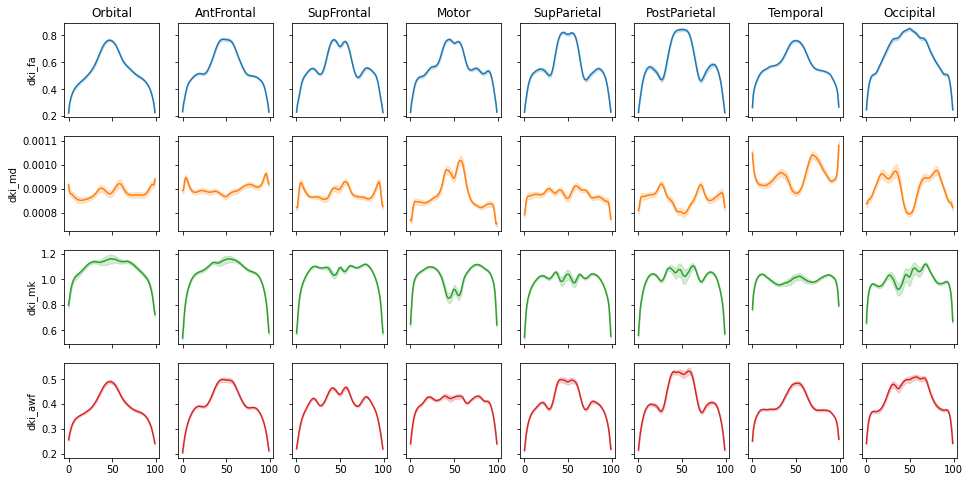

In [684]:
def _summary_stats(df):
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    colors = sns.color_palette()

    # order bundles front to back
    df1 = df.copy()
    df1['tractID'] = pd.Categorical(
        df1['tractID'], 
        categories=["Orbital", "AntFrontal", "SupFrontal", "Motor", "SupParietal", "PostParietal", "Temporal", "Occipital"],
        ordered=True
    )
    
    df_grouped = df1.groupby('tractID')
    
    fig, axs = plt.subplots(nrows=len(_scalars), ncols=len(_tracts), sharex=True, sharey='row', figsize=(16,8))
    axs = axs.ravel()
    
    for row_id, (bundle_name, group) in enumerate(df_grouped):
        axs[row_id].set_title(bundle_name)
        for scalar in _scalars:
            sns.lineplot(
                ax=axs[_scalars.index(scalar)*len(df_grouped)+row_id], 
                data=group[scalar].rename(lambda x: x % len(_nodes)),
                color=colors[_scalars.index(scalar)]
            )
    plt.show()

_summary_stats(df)

## Tensor

In [600]:
def get_data_tensor(df, scalars = _scalars):
    import pandas as pd
    
    df1 = df.groupby(['subjectID', 'tractID', 'nodeID'])[scalars].apply(pd.DataFrame)
    data = df1.values.reshape(len(df.subjectID.unique()), len(df.tractID.unique()), len(df.nodeID.unique()), len(scalars))
    return data.transpose(0,1,3,2)

In [603]:
def get_dataframe_from_tensor(tensor):
    import pandas as pd
    import numpy as np

    df = pd.DataFrame(tensor.transpose(2,0,1,3).reshape([len(_scalars), len(_subjects)*len(_tracts)*len(_nodes)]).T)
    df.columns = _scalars
    df['nodeID'] = list(_nodes)*(len(_subjects)*len(_tracts))
    df['tractID'] = list(np.repeat(_tracts,len(_nodes)))*len(_subjects)
    df['subjectID'] = list(np.repeat(_subjects,len(_tracts)*len(_nodes)))
    
    return df

In [685]:
data = get_data_tensor(df)
data.shape

(44, 8, 4, 100)

sanity check

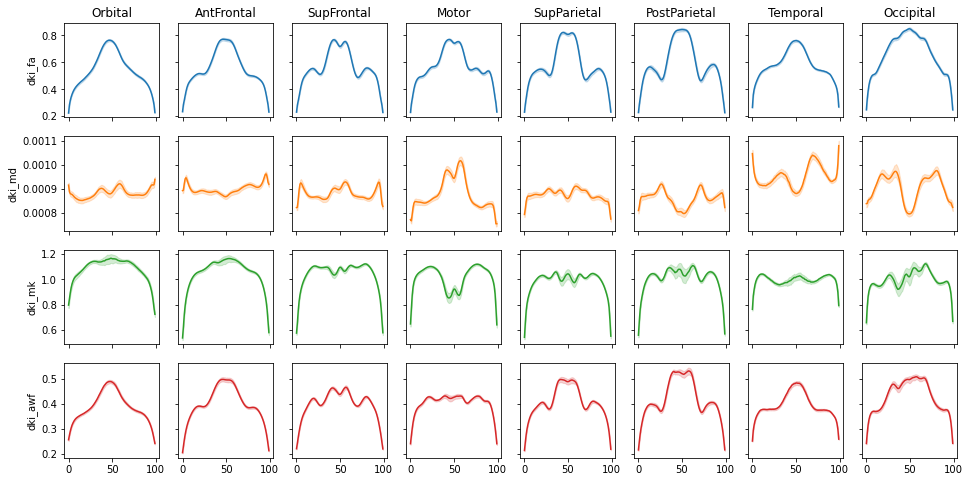

In [686]:
_summary_stats(get_dataframe_from_tensor(data))

## TCA

Try various:
- fit methods (ncp_hals, mcp_als, ...)
- number of components (1-9 ... 30)
- number of replications (4)

**Concerns**

does data characterization dictate certain constraints on TCA?
- sparsity - (not sparse)
- nonnegative / postitivity constraint (all scalars are positive, maybe should be constraint on TCA)
- normalized values (MD is not similar scale)

In [131]:
def tca(data, fit_method = "ncp_hals", max_r = 9, n_replicates = 4):
    import tensortools as tt
    ensemble = tt.Ensemble(fit_method=fit_method)
    ensemble.fit(data, ranks=range(1, max_r), replicates=n_replicates, verbose=False)
    return ensemble

In [635]:
def plot_analysis(ensemble):
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 2)
    tt.plot_objective(ensemble, ax=axes[0]) 
    tt.plot_similarity(ensemble, ax=axes[1])
    fig.tight_layout()
    
def plot_factors(ensemble, num_components = 8, replicate = 0):
    import matplotlib.pyplot as plt
    fig, axes, plot_obj = tt.plot_factors(ensemble.factors(num_components)[replicate])
    for ax in axes.flat:
        ax.axhline(y=0, c="red", ls="--")
        
    for ax in axes[:,1]:
        ax.set_xticks(list(range(len(_tracts))))
        ax.set_xticklabels(_tracts, rotation = 90, ha='center')
        
    for ax in axes[:,2]:
        ax.set_xticks(list(range(len(_scalars))))
        ax.set_xticklabels(_scalars, rotation = 90, ha='center')

    plt.show()

### Subject x Bundle x Scalar (mean)

In [687]:
ensemble_agg = tca(data.mean(axis=3))

Rank-1 models:  min obj, 0.04;  max obj, 0.04;  time to fit, 0.0s


Rank-2 models:  min obj, 0.02;  max obj, 0.03;  time to fit, 0.0s


Rank-3 models:  min obj, 0.02;  max obj, 0.03;  time to fit, 0.1s


Rank-4 models:  min obj, 0.02;  max obj, 0.02;  time to fit, 0.1s


Rank-5 models:  min obj, 0.02;  max obj, 0.02;  time to fit, 0.1s


Rank-6 models:  min obj, 0.02;  max obj, 0.02;  time to fit, 0.2s


Rank-7 models:  min obj, 0.01;  max obj, 0.02;  time to fit, 0.1s


Rank-8 models:  min obj, 0.02;  max obj, 0.02;  time to fit, 0.1s


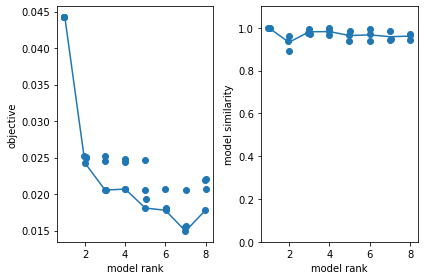

In [688]:
plot_analysis(ensemble_agg)

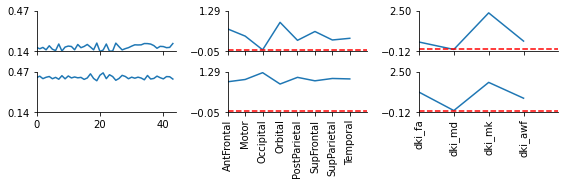

In [689]:
plot_factors(ensemble_agg, num_components=2)

### Subject x Bundle x Scalar x Node

In [690]:
ensemble = tca(data)

Rank-1 models:  min obj, 0.11;  max obj, 0.11;  time to fit, 0.0s


Rank-2 models:  min obj, 0.08;  max obj, 0.08;  time to fit, 0.3s


Rank-3 models:  min obj, 0.07;  max obj, 0.08;  time to fit, 1.3s


Rank-4 models:  min obj, 0.06;  max obj, 0.08;  time to fit, 1.3s


Rank-5 models:  min obj, 0.06;  max obj, 0.07;  time to fit, 1.9s


Rank-6 models:  min obj, 0.06;  max obj, 0.07;  time to fit, 1.4s


Rank-7 models:  min obj, 0.06;  max obj, 0.06;  time to fit, 1.5s


Rank-8 models:  min obj, 0.05;  max obj, 0.06;  time to fit, 2.9s


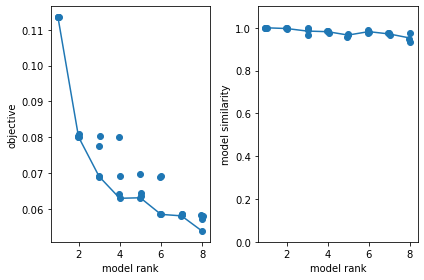

In [691]:
plot_analysis(ensemble)

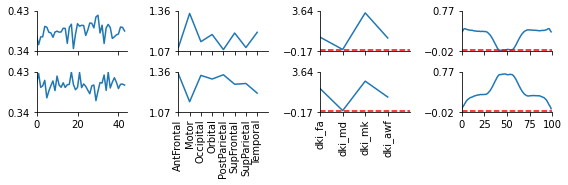

In [692]:
plot_factors(ensemble, num_components=2)

## Masked Cross Validation

Effects of different mask percentages

In [693]:
def masked_als(data, max_r=9, n_replicates=4, mask_pct=.1):
    import numpy as np
    import tensortools as tt
    import functools
    
    mask = np.random.rand(*data.shape) > mask_pct
    mcp_als = functools.partial(tt.mcp_als, mask=mask, verbose=False)
    ensemble = tca(data, fit_method=mcp_als, max_r=max_r)
    
    return ensemble, mask

ensemble, mask = masked_als(data)

Rank-1 models:  min obj, 0.11;  max obj, 0.11;  time to fit, 0.1s


Rank-2 models:  min obj, 0.08;  max obj, 0.08;  time to fit, 4.6s


Rank-3 models:  min obj, 0.07;  max obj, 0.07;  time to fit, 4.1s


Rank-4 models:  min obj, 0.06;  max obj, 0.06;  time to fit, 8.1s


Rank-5 models:  min obj, 0.06;  max obj, 0.06;  time to fit, 14.5s


Rank-6 models:  min obj, 0.05;  max obj, 0.05;  time to fit, 13.5s


Rank-7 models:  min obj, 0.05;  max obj, 0.05;  time to fit, 12.2s


Rank-8 models:  min obj, 0.05;  max obj, 0.05;  time to fit, 13.5s


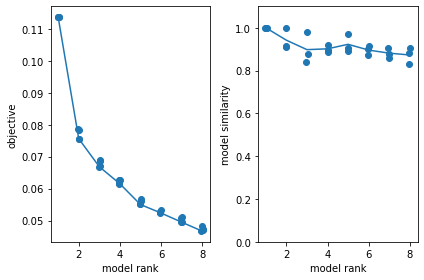

number of components: 1, replicate: 0


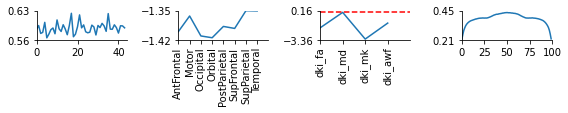

number of components: 2, replicate: 0


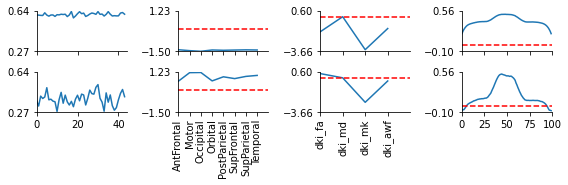

number of components: 3, replicate: 0


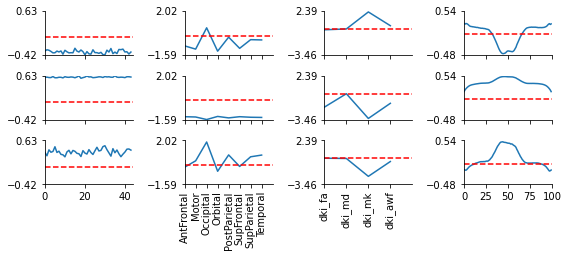

number of components: 4, replicate: 0


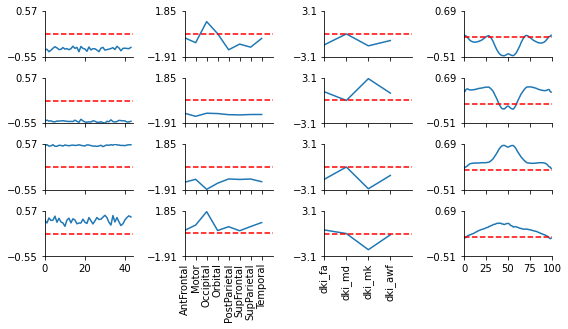

number of components: 5, replicate: 0


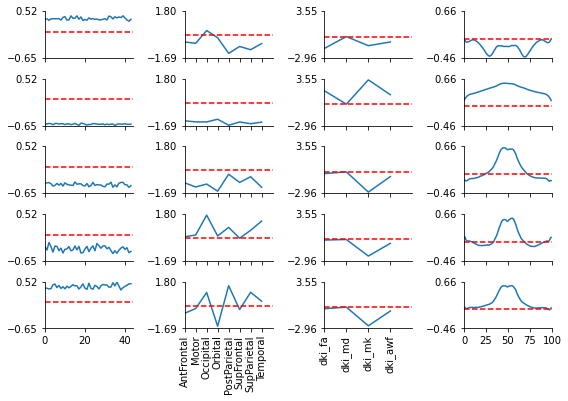

number of components: 6, replicate: 0


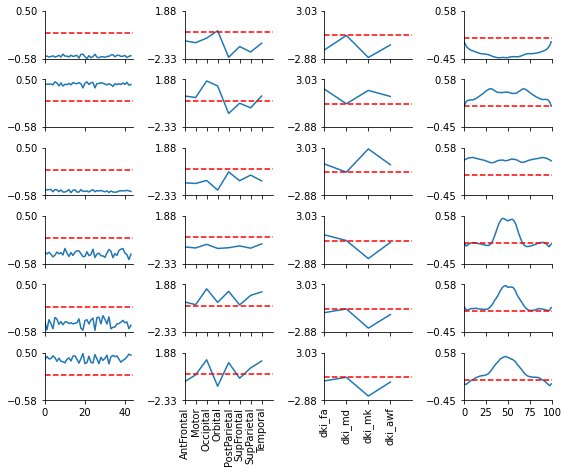

number of components: 7, replicate: 0


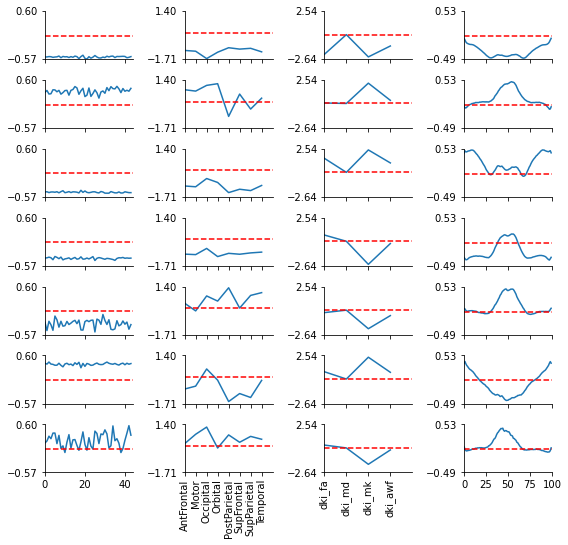

number of components: 8, replicate: 0


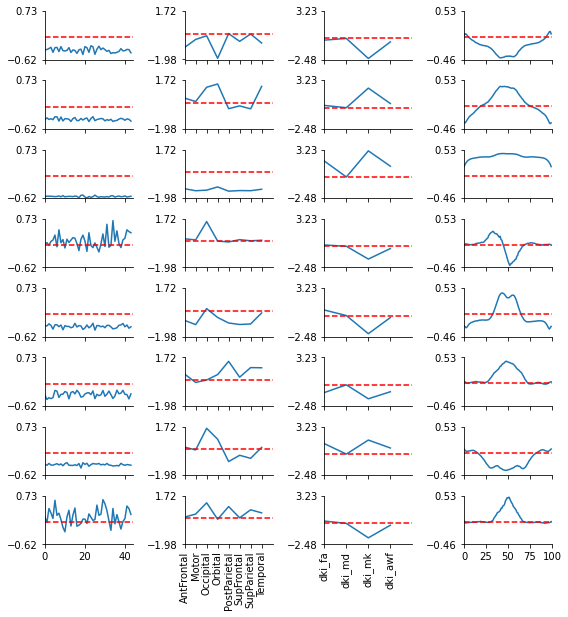

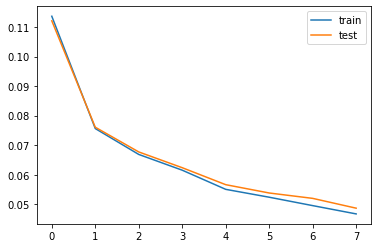

In [694]:
def vis_masked(data, ensemble, mask, max_r=9, n_replicates=4, all_replicates=False):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    
    plot_analysis(ensemble)
    plt.show()

    error = {}
    
    for replicate in range(0, n_replicates):
        error[replicate] = {'train': [], 'test': []}
        
        if not all_replicates:
            break

    for r in range(1, max_r):
        for replicate in range(0, n_replicates):
            print(f'number of components: {r}, replicate: {replicate}')
            plot_factors(ensemble, num_components=r, replicate=replicate)

            data_hat = ensemble.factors(r)[replicate].full()
            
            error[replicate]['train'].append(np.linalg.norm(data_hat[mask] - data[mask]) / np.linalg.norm(data[mask]))
            error[replicate]['test'].append(np.linalg.norm(data_hat[~mask] - data[~mask]) / np.linalg.norm(data[~mask]))

            if not all_replicates:
                break


    df = pd.DataFrame({(replicate,trial): error[replicate][trial] 
                            for replicate in error.keys() 
                            for trial in error[replicate].keys()})

    for replicate in range(0, n_replicates):
        df[replicate].plot()
        plt.show()
        
        if not all_replicates:
            break

vis_masked(data, ensemble, mask)

## Analysis

### Significant difference in signatures between/among factors?

Are factors correlated?

 - Compare factors within replicate given number of components
 - Compare factors across replicates for given number of components
 - Compare factors across components
 
**Concerns**
 - Are there sufficent numbers of samples to have confidence in p-values
 - Is stacking the factors valid? Since some factors are larger than others not weighted equivallently
 - would ANOVA be more appropriate?

### PCA projection of factor

groups or clusters?

subject matrix PCA projection


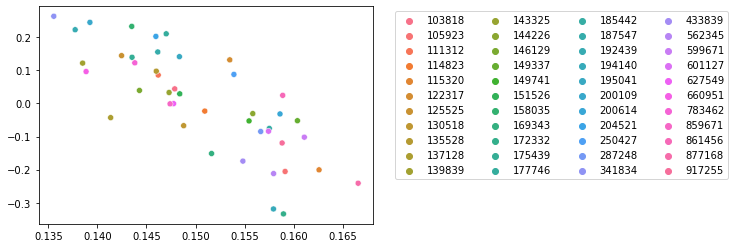

bundle matrix PCA projection


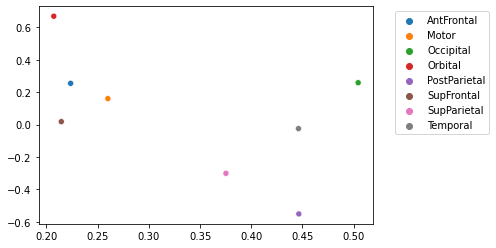

scalar matrix PCA projection


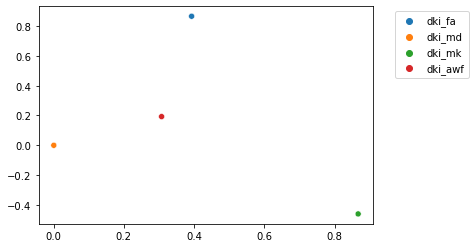

node matrix PCA projection


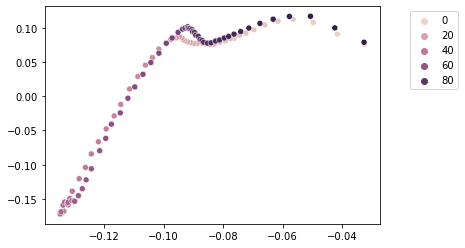

In [695]:
def viz_factor(ensemble, n_components=8, replicate=0):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=2)
    
    print('subject matrix PCA projection')
    pca.fit(ensemble.factors(n_components)[replicate].factors[0].T)
    sns.scatterplot(x=pca.components_[0],y=pca.components_[1], hue=df.subjectID.unique())
    plt.legend(bbox_to_anchor=(1.05, 1), ncol=4)
    plt.show()

    
    print('bundle matrix PCA projection')
    pca.fit(ensemble.factors(n_components)[replicate].factors[1].T)
    sns.scatterplot(x=pca.components_[0],y=pca.components_[1], hue=df.tractID.unique())
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()
    
    print('scalar matrix PCA projection')
    pca.fit(ensemble.factors(n_components)[replicate].factors[2].T)
    sns.scatterplot(x=pca.components_[0],y=pca.components_[1], hue=_scalars)
    plt.legend(bbox_to_anchor=(1.3, 1))
    plt.show()
    
    print('node matrix PCA projection')
    pca.fit(ensemble.factors(n_components)[replicate].factors[3].T)
    sns.scatterplot(x=pca.components_[0],y=pca.components_[1], hue=df.nodeID.unique())
    plt.legend(bbox_to_anchor=(1.25, 1))
    plt.show()
    
viz_factor(ensemble, n_components=6)

Factor p

subject by bundle


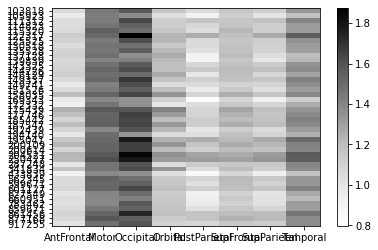

subject by scalar


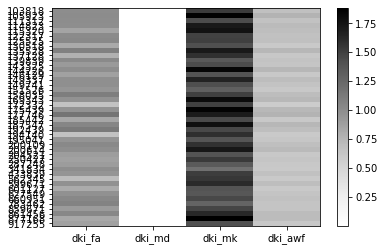

subject by node


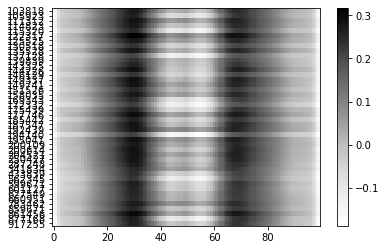

bundle by scalar


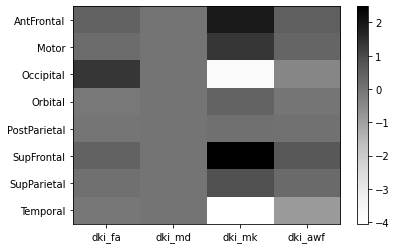

bundle by node


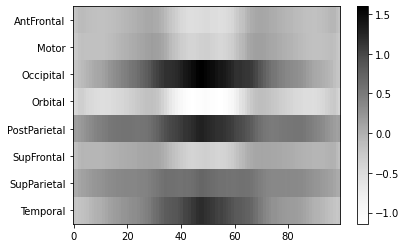

scalar by node


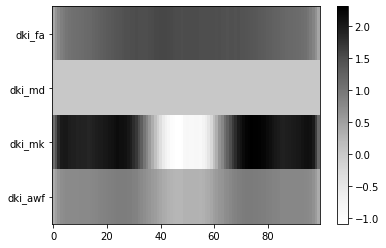

In [696]:
def viz_factor_product(ensemble, n_components=8, replicate=0):
    import numpy as np
    import matplotlib.pyplot as plt
    
    
    print('subject by bundle')
    plt.imshow(np.dot(ensemble.factors(n_components)[replicate].factors[0],ensemble.factors(n_components)[replicate].factors[1].T), aspect='auto', cmap='Greys', interpolation='none')
    plt.xticks(range(len(_tracts)), _tracts)
    plt.yticks(range(len(_subjects)), _subjects)
    plt.colorbar()
    plt.show()
    
    print('subject by scalar')
    plt.imshow(np.dot(ensemble.factors(n_components)[replicate].factors[0],ensemble.factors(n_components)[replicate].factors[2].T), aspect='auto', cmap='Greys', interpolation='none')
    plt.xticks(range(len(_scalars)), _scalars)
    plt.yticks(range(len(_subjects)), _subjects)
    plt.colorbar()
    plt.show()
    
    print('subject by node')
    plt.imshow(np.dot(ensemble.factors(n_components)[replicate].factors[0],ensemble.factors(n_components)[replicate].factors[3].T), aspect='auto', cmap='Greys', interpolation='none')
    plt.yticks(range(len(_subjects)), _subjects)
    plt.colorbar()
    plt.show()
    
    print('bundle by scalar')
    plt.imshow(np.dot(ensemble.factors(n_components)[replicate].factors[1],ensemble.factors(n_components)[replicate].factors[2].T), aspect='auto', cmap='Greys', interpolation='none')
    plt.xticks(range(len(_scalars)), _scalars)
    plt.yticks(range(len(_tracts)), _tracts)
    plt.colorbar()
    plt.show()
    
    print('bundle by node')
    plt.imshow(np.dot(ensemble.factors(n_components)[replicate].factors[1],ensemble.factors(n_components)[replicate].factors[3].T), aspect='auto', cmap='Greys', interpolation='none')
    plt.yticks(range(len(_tracts)), _tracts)
    plt.colorbar()
    plt.show()
    
    print('scalar by node')
    plt.imshow(np.dot(ensemble.factors(n_components)[replicate].factors[2],ensemble.factors(n_components)[replicate].factors[3].T), aspect='auto', cmap='Greys', interpolation='none')
    plt.yticks(range(len(_scalars)), _scalars)
    plt.colorbar()
          
viz_factor_product(ensemble, n_components=6)

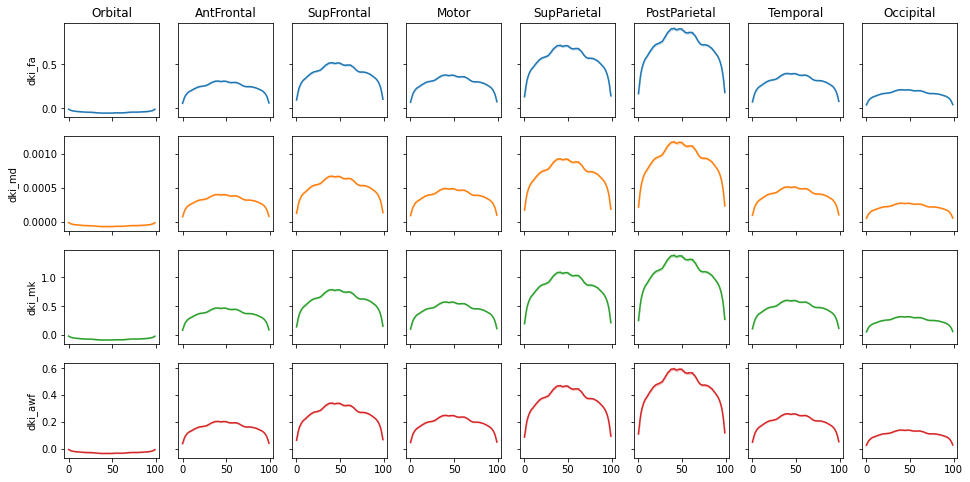

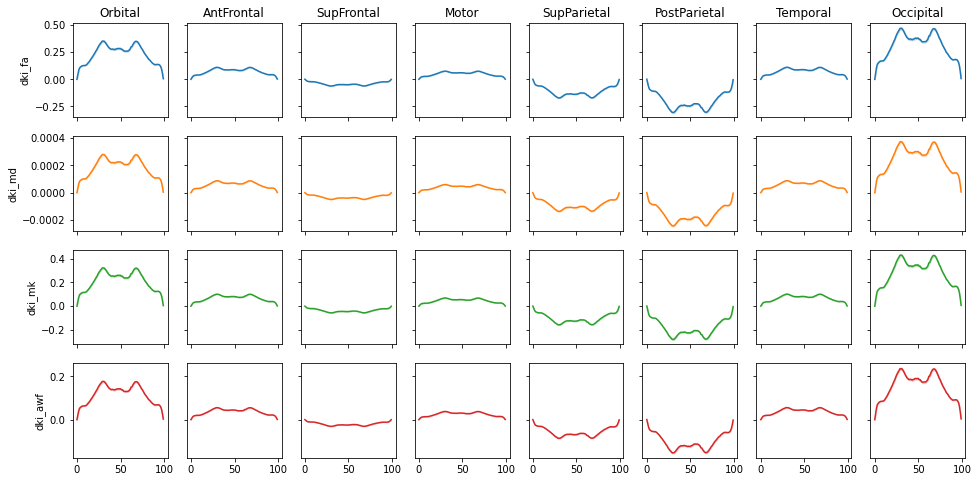

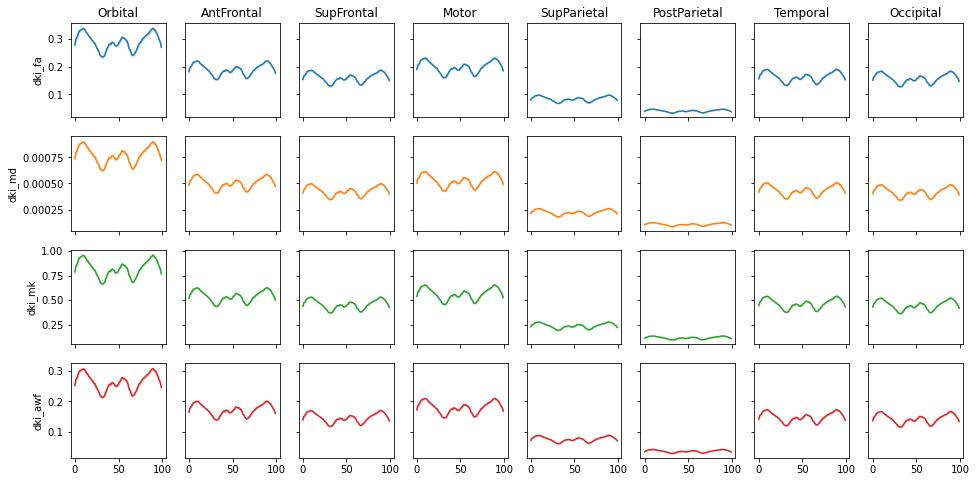

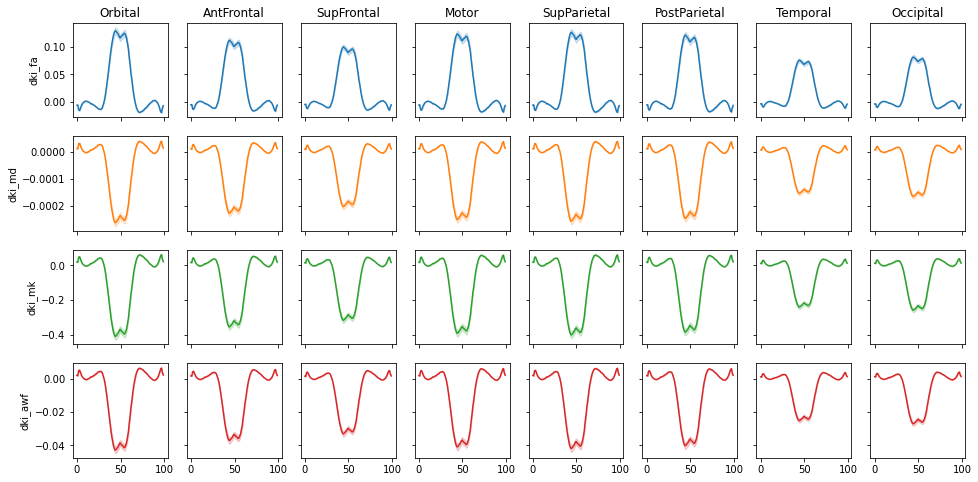

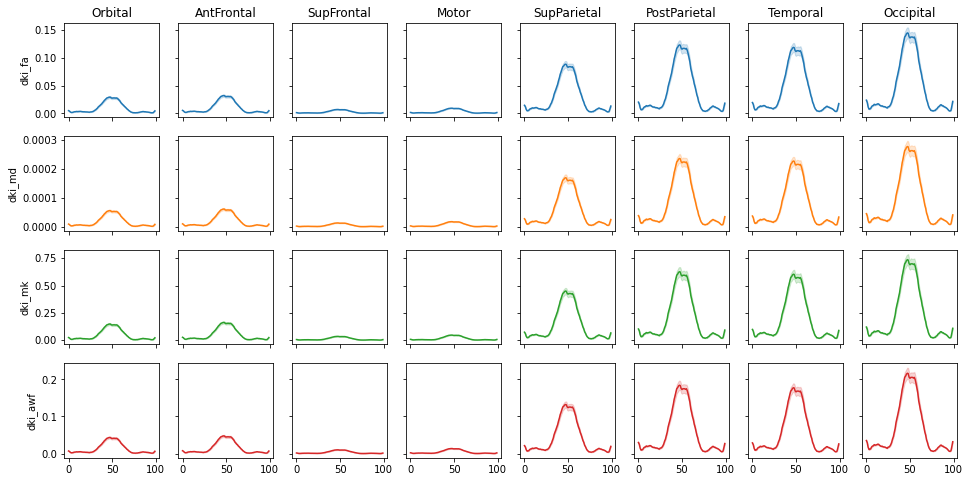

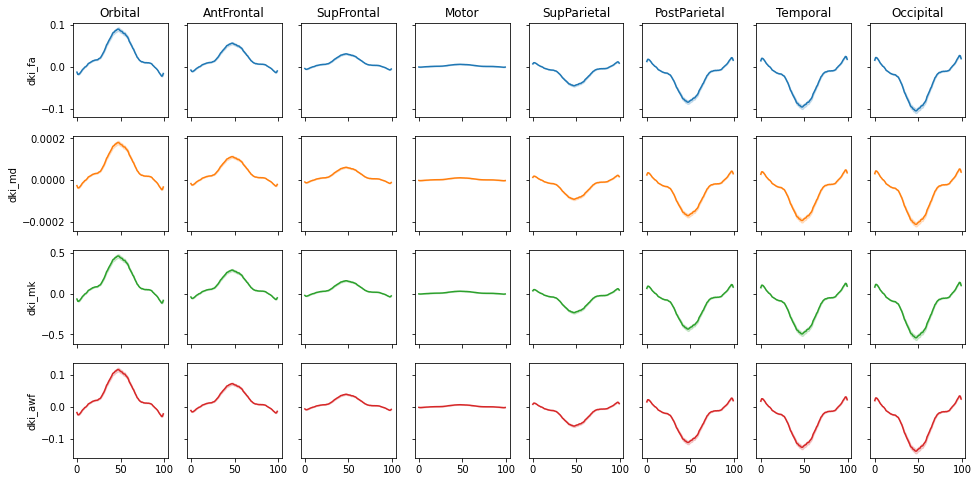

In [697]:
def project(ensemble, n_components=8, replicate=0):
    from tensortools.operations import khatri_rao
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    colors = sns.color_palette()
    
    ktensor = ensemble.factors(n_components)[replicate]
    
    for i in range(n_components):
        factor_tensor = khatri_rao(ktensor.factors)[:,i].reshape(ktensor.shape)
        _summary_stats(get_dataframe_from_tensor(factor_tensor))
        

project(ensemble, n_components=6)

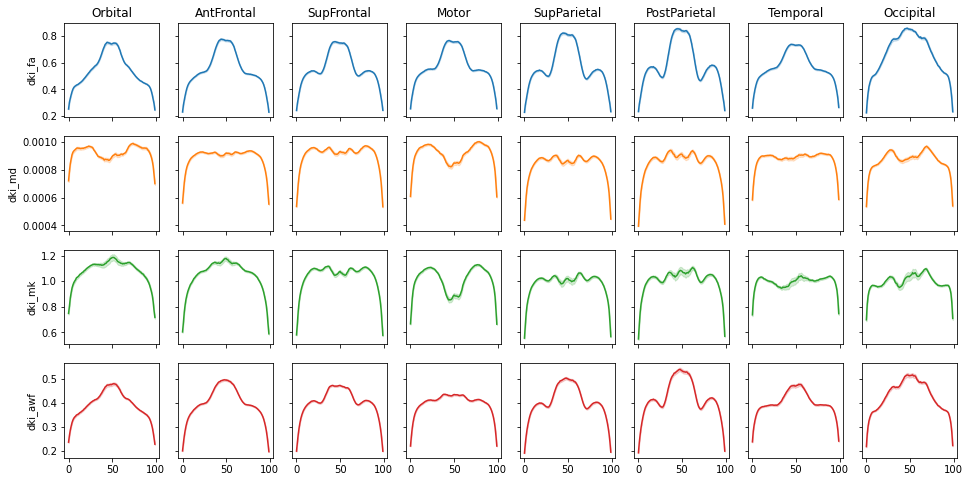

In [698]:
_summary_stats(get_dataframe_from_tensor(ensemble.factors(6)[0].full()))

## Behavioral

In [830]:
def _get_behavioral(numeric=False, normalize=True):
    """
    https://wiki.humanconnectome.org/display/PublicData/HCP-YA+Data+Dictionary-+Updated+for+the+1200+Subject+Release#HCPYADataDictionaryUpdatedforthe1200SubjectRelease-Category:Cognition
    """
    import pandas as pd
    import numpy as np
    
    df = pd.read_csv('unrestricted_test-restest_behavioral.csv')
    
    if numeric:
        df = df[df['Subject'].isin(list(map(int, _subjects)))]
        df = df.drop(columns=['Subject'])
        df = df.select_dtypes(include=np.number)
        
        if normalize:
            df=(df-df.mean())/df.std()
            df = df.fillna(0)
            df.replace([np.inf, -np.inf], 0,inplace=True)

    return df

def _get_alertness(normalize=True):
    df = _get_behavioral()[
        [
            'Subject',
            # Cognitive Status (Mini Mental Status Exam)
            'MMSE_Score',
            # Sleep (Pittsburgh Sleep Questionnaire)
            'PSQI_Score',
        ]
    ]
    
    df = df[df['Subject'].isin(list(map(int, _subjects)))]
    df = df.drop(columns=['Subject'])
    if normalize:
        df=(df-df.mean())/df.std()
    return df

def _get_cognitive(normalize=True):
    df = _get_behavioral()[
        [
            'Subject',
            # Episodic Memory (Picture Sequence Memory)
            'PicSeq_Unadj',
            # Executive Function/Cognitive Flexibility (Dimensional Change Card Sort)
            'CardSort_Unadj',
            # Executive Function/Inhibition (Flanker Task)
            'Flanker_Unadj',
            # Fluid Intelligence (Penn Progressive Matrices)
            'PMAT24_A_CR',
            'PMAT24_A_SI',
            'PMAT24_A_RTCR',
            # Language/Reading Decoding (Oral Reading Recognition)
            'ReadEng_Unadj',
            # Language/Vocabulary Comprehension (Picture Vocabulary)
            'PicVocab_Unadj',
            # Processing Speed (Pattern Completion Processing Speed)
            'ProcSpeed_Unadj',
            # Self-regulation/Impulsivity (Delay Discounting)
            'DDisc_SV_1mo_200',
            'DDisc_SV_6mo_200',
            'DDisc_SV_1yr_200',
            'DDisc_SV_3yr_200',
            'DDisc_SV_5yr_200',
            'DDisc_SV_10yr_200',
            'DDisc_SV_1mo_40K',
            'DDisc_SV_6mo_40K',
            'DDisc_SV_1yr_40K',
            'DDisc_SV_3yr_40K',
            'DDisc_SV_5yr_40K',
            'DDisc_SV_10yr_40K',
            'DDisc_AUC_200',
            'DDisc_AUC_40K',
            # Spatial Orientation (Variable Short Penn Line Orientation Test)
            'VSPLOT_TC',
            'VSPLOT_CRTE',
            'VSPLOT_OFF',
            # Sustained Attention (Short Penn Continuous Performance Test)
            'SCPT_TP',
            'SCPT_TN',
            'SCPT_FP',
            'SCPT_FN',
            'SCPT_TPRT',
            'SCPT_SEN',
            'SCPT_SPEC',
            'SCPT_LRNR',
            # Verbal Episodic Memory (Penn Word Memory Test)
            'IWRD_TOT',
            'IWRD_RTC',
            # Working Memory (List Sorting)
            'ListSort_Unadj'
        ]
    ]
    
    df = df[df['Subject'].isin(list(map(int, _subjects)))]
    df = df.drop(columns=['Subject'])
    if normalize:
        df=(df-df.mean())/df.std()
    return df

def _get_emotion(normalize=True):
    df = _get_behavioral()[
        [
            'Subject',
            # Emotion Recognition (Penn Emotion Recognition Test)
            'ER40_CR',
            'ER40_CRT',
            'ER40ANG',
            'ER40FEAR',
            'ER40HAP',
            'ER40NOE',
            'ER40SAD',
            # Negative Affect 
            'AngAffect_Unadj',
            'AngHostil_Unadj',
            'AngAggr_Unadj',
            'FearAffect_Unadj',
            'FearSomat_Unadj',
            'Sadness_Unadj',
            # Psychological Well-being 
            'LifeSatisf_Unadj',
            'MeanPurp_Unadj',
            'PosAffect_Unadj',
            # Social Relationships 
            'Friendship_Unadj',
            'Loneliness_Unadj',
            'PercHostil_Unadj',
            'PercReject_Unadj',
            'EmotSupp_Unadj',
            'InstruSupp_Unadj',
            # Stress and Self Efficacy
            'PercStress_Unadj',
            'SelfEff_Unadj'
        ]
    ]
    df = df[df['Subject'].isin(list(map(int, _subjects)))]
    df = df.drop(columns=['Subject'])
    if normalize:
        df=(df-df.mean())/df.std()
    return df
    

def _get_motor(normalize=True):
    df = _get_behavioral()[
        [
            'Subject',
            # Endurance (2 minute walk test)
            'Endurance_Unadj',
            # Locomotion (4-meter walk test)
            'GaitSpeed_Comp',
            # Dexterity (9-hole Pegboard)
            'Dexterity_Unadj',
            # Strength (Grip Strength Dynamometry)
            'Strength_Unadj'
        ]
    ]
    df = df[df['Subject'].isin(list(map(int, _subjects)))]
    df = df.drop(columns=['Subject'])
    if normalize:
        df=(df-df.mean())/df
    return df

def _get_personality(normalize=True):
    df = _get_behavioral()[
        [
            'Subject',
            # Five Factor Model (NEO-FFI)
            'NEOFAC_A',
            'NEOFAC_O',
            'NEOFAC_C',
            'NEOFAC_N',
            'NEOFAC_E'
        ]
    ]
    df = df[df['Subject'].isin(list(map(int, _subjects)))]
    df = df.drop(columns=['Subject'])
    if normalize:
        df=(df-df.mean())/df
    return df

def _get_psych(normalize=True):
    raise NotImplementedError('all values are restricted')
    
def _get_sensory(normalize=True):
    import numpy as np
    df = _get_behavioral()[
        [
            'Subject',
            # Audition (Words in Noise)
            'Noise_Comp',
            # Olfaction (Odor Identification Test)
            'Odor_Unadj',
            # Pain (Pain Intensity and Interference Surveys)
            'PainInterf_Tscore',
            # Taste (Taste Intensity Test)
            'Taste_Unadj',
            # Contrast Sensitivity (Mars Contrast Sensitivity)
            'Mars_Log_Score',
            'Mars_Errs',
            'Mars_Final'
        ]
    ]
    df = df[df['Subject'].isin(list(map(int, _subjects)))]
    df = df.drop(columns=['Subject'])
    if normalize:
        df=(df-df.mean())/df
        df = df.fillna(0)
        df.replace([np.inf, -np.inf], 0,inplace=True)
    return df
    
def _get_substance_use(normalize=True):
    raise NotImplementedError('all values are restricted')

behav_df = _get_behavioral(numeric=True)
alrt_df = _get_alertness()
cog_df = _get_cognitive()
emot_df = _get_emotion()
motor_df = _get_motor()
pers_df = _get_personality()
sense_df = _get_sensory()

In [768]:
def _get_subject_factors_df(ensemble, normalize=True):
    import pandas as pd
    
    df = pd.DataFrame(ensemble.factors(6)[0].factors[0])
    
    if normalize:
        df=(df-df.mean())/df.std()

    return df

sub_fact_df = _get_subject_factors_df(ensemble)

#### MANOVA

Determine if there is any relationship between the behavoiral observations and subject factors at all. Perhaps the they are completely unrelated to one another and independent

Wilks lambda is a ratio of two variance-covariance matrices, and if the values of these statistics are large (small p-value), then we reject the null hypothesis that there is no relationship between the behavoiral and subject factors and conclude that theyare dependent.

In [945]:
def _manova(X, Y):
    from statsmodels.multivariate.manova import MANOVA
    manova = MANOVA(endog=X, exog=Y)
    print(manova.mv_test())

_manova(sub_fact_df.to_numpy(), cog_df.to_numpy())

ValueError: Covariance of x singular!

In [946]:
def _manova(X, Y):
    import pandas as pd
    from statsmodels.multivariate.manova import MANOVA

    X.reset_index(drop=True, inplace=True)
    X = X.add_prefix('factor_')
    Y.reset_index(drop=True, inplace=True)
    df = pd.concat([X, Y], axis=1)
    # alertness
#     manova = MANOVA.from_formula('factor_0 + factor_1 + factor_2 + factor_3 + factor_4 + factor_5 ~ MMSE_Score + PSQI_Score', data=df)
    manova = MANOVA.from_formula('factor_0 + factor_1 + factor_2 + factor_3 + factor_4 + factor_5 ~ ReadEng_Unadj', data=df)
    print(manova.mv_test())

_manova(sub_fact_df, cog_df)

                    Multivariate linear model
                                                                  
------------------------------------------------------------------
       Intercept          Value   Num DF  Den DF  F Value   Pr > F
------------------------------------------------------------------
          Wilks' lambda    0.0003 6.0000 37.0000 19345.4298 0.0000
         Pillai's trace    0.9997 6.0000 37.0000 19345.4298 0.0000
 Hotelling-Lawley trace 3137.0967 6.0000 37.0000 19345.4298 0.0000
    Roy's greatest root 3137.0967 6.0000 37.0000 19345.4298 0.0000
------------------------------------------------------------------
                                                                  
-------------------------------------------------------------------
       ReadEng_Unadj       Value   Num DF   Den DF  F Value  Pr > F
-------------------------------------------------------------------
            Wilks' lambda  0.7888  6.0000  37.0000   1.6514  0.1607
           P

**Cannot reject the null hypothesis Reading Scores and Subject factors may be unrelated (independent)**

#### Linear Regression
Predicting Reading Score using a linear model with boostrapped five fold (KFold) cross validation

From Jasons studies know that FA is loaded in posterior callosum and associated with reading scores

In [ ]:
def _predict_reading(factors=sub_fact_df, reading_score=behav_df['ReadEng_Unadj']):
    from sklearn.linear_model import LinearRegression
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import KFold
    from sklearn.metrics import r2_score
    from scipy.stats import scoreatpercentile
    import numpy as np
    import matplotlib.pyplot as plt

    factors.reset_index(drop=True, inplace=True)
    reading_score.reset_index(drop=True, inplace=True)
    
    n_bootstrap_samples = 1000
    to_sample = np.arange(factors.shape[0])
    r2 = []
    
    for bb in np.arange(n_bootstrap_samples):
        # sampling with replacement
        idx = np.random.choice(to_sample, size=factors.shape[0])
        X = factors.iloc[idx]
        y = reading_score.iloc[idx]

        pipe = Pipeline([
                ('scale', StandardScaler()),
                ('lm', LinearRegression(fit_intercept=True))])

        kf = KFold() # Default is 5-fold

        y_hats = []
        y_true = []
        
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values
            pipe.fit(X_train, y_train)
            y_true.append(y_test)
            y_hats.append(pipe.predict(X_test))

        y_true = np.concatenate(y_true)
        y_hats = np.concatenate(y_hats)

        r2.append(r2_score(y_true, y_hats))

    
    
    plt.hist(r2, density=True, bins=50)
    plt.title('r2 score distribution')
    plt.xlabel('r2 score')
    plt.show()
    
    is_it_good = scoreatpercentile(r2, 2.5)
    print(is_it_good)
    print(is_it_good > 0)
    
_predict_reading(
    _get_subject_factors_df(ensemble, normalize=False), 
    _get_behavioral(numeric=True, normalize=False)['ReadEng_Unadj']
)

**Linear model is not a good fit to predict Reading Scores**

#### CCA

We hope to find linear combinations that maximize the correlations between the members of each canonical variate pair.

In [937]:
def _cca(X_mc, Y_mc, title=None):
    from sklearn.cross_decomposition import CCA
    import pandas as pd
    import seaborn as sns
    import numpy as np
    
    ca = CCA()
    ca.fit(X_mc, Y_mc)
    X_c, Y_c = ca.transform(X_mc, Y_mc)
    
    cc_res = pd.DataFrame({"CCX_1":X_c[:, 0],
                       "CCY_1":Y_c[:, 0],
                       "CCX_2":X_c[:, 1],
                       "CCY_2":Y_c[:, 1]})
                          
    sns.scatterplot(x="CCX_1",
                y="CCY_1", 
                data=cc_res)
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = x_vals
    plt.plot(x_vals, y_vals, 'r--')
    plt.title(title)
    plt.show()

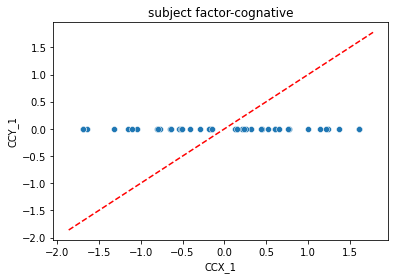

In [947]:
_cca(sub_fact_df, cog_df, 'subject factor-cognative')
# _cca(sub_fact_df, alrt_df)
# _cca(sub_fact_df, cog_df)
# _cca(sub_fact_df, emot_df)
# _cca(sub_fact_df, motor_df)
# _cca(sub_fact_df, pers_df)
# _cca(sub_fact_df, sense_df)

##### shuffle subject factors

put in noise to see if breaks CCA

In [948]:
sub_fact_df_shuff = sub_fact_df.sample(frac=1)
# display(sub_fact_df_shuff)

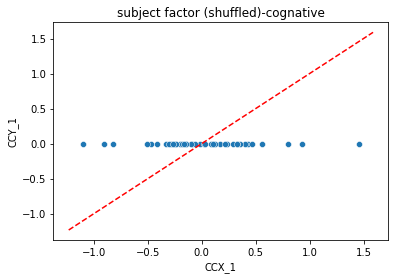

In [949]:
_cca(sub_fact_df_shuff, cog_df, 'subject factor (shuffled)-cognative')

**Dispite shuffling data CCA still found a relationship**

Likely means that CCA is not meaningful